## Dissertation Data Cleaning and Early Modelling
### Gavin Rolls

Migrated from OvertureTest.ipynb. I've queried all of my Overture and OSM data in DataCollection.ipynb
This document is dedicated to cleaning my data and running some early iterations of employment models

### Imports

In [7]:
#Basics
import pandas as pd
import geopandas as gpd

#Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder

#Shapely
from geopy.geocoders import Nominatim
from shapely.geometry import box
from shapely import wkt
from shapely.geometry import Polygon, MultiPolygon
from shapely.geometry import mapping
from shapely.geometry import shape

#Plots!
import matplotlib.pyplot as plt

#Spatial Indexing
import h3

#Warning Supression
import warnings

## Data Loading + Cleaning

### UK BRES Employment Data

In [47]:
#Skip the first six rows because they're header information
empl_data = pd.read_csv('data/employment_data/lsoa_by_industry_london.csv', skiprows=7, delimiter=',')

unnamed_cols = empl_data.columns[empl_data.columns.str.contains('^Unnamed:')]
empl_data.drop(columns=unnamed_cols, inplace=True)

#Separate name into LSOA11CD and LSOA11NM
def split_column(value):
    #Keep Greater London stats
    if value.startswith('gor:'):
        return value, value
    #Split into name and code
    else:
        parts = value.split('lsoa2011:')[1]
        code, name = parts.split(' : ')
        return code.strip(), name.strip()
        return code, name

empl_data[['LSOA11CD', 'LSOA11NM']] = empl_data['Area'].apply(lambda x: pd.Series(split_column(x)))

print("Num Rows (LSOAs) Before Cleaning: " + str(empl_data.shape[0]))

#There appear to be a bunch of duplicates so I'm going to get rid of them now
empl_data.drop_duplicates(inplace=True)

print("Num Rows (LSOAs) After Cleaning: " + str(empl_data.shape[0]))

Num Rows (LSOAs) Before Cleaning: 9478
Num Rows (LSOAs) After Cleaning: 4836


In [49]:
#Create Total Column
empl_data['total'] = empl_data[empl_data.columns[1:-2]].sum(axis=1)

empl_data.head()

,Area,"01 : Crop and animal production, hunting and related service activities",02 : Forestry and logging,03 : Fishing and aquaculture,05 : Mining of coal and lignite,06 : Extraction of crude petroleum and natural gas,07 : Mining of metal ores,08 : Other mining and quarrying,09 : Mining support service activities,10 : Manufacture of food products,...,93 : Sports activities and amusement and recreation activities,94 : Activities of membership organisations,95 : Repair of computers and personal and household goods,96 : Other personal service activities,97 : Activities of households as employers of domestic personnel,98 : Undifferentiated goods- and services-producing activities of private households for own use,99 : Activities of extraterritorial organisations and bodies,LSOA11CD,LSOA11NM,total
0,gor:London,1250,1250,400,0,1500,0,450,350,32000,...,56000,57000,17000,62000,0,0,0,gor:London,gor:London,5605320
1,lsoa2011:E01000907 : Camden 001A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,E01000907,Camden 001A,115
2,lsoa2011:E01000908 : Camden 001B,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,E01000908,Camden 001B,180
3,lsoa2011:E01000909 : Camden 001C,0,0,0,0,0,0,0,0,0,...,0,0,0,5,0,0,0,E01000909,Camden 001C,200
4,lsoa2011:E01000912 : Camden 001D,0,0,0,0,0,0,0,0,0,...,0,0,0,5,0,0,0,E01000912,Camden 001D,825


### LSOA Geographic Data

In [53]:
#Get London LSOA Shapefile Data
lsoa_geo = gpd.read_file('data/lsoa_data/LSOA_2011_London_gen_MHW.shp')

#Convert to WGS for consistency
lsoa_geo = lsoa_geo.to_crs(epsg=4326)
lsoa_geo = lsoa_geo.drop(lsoa_geo.columns[list(range(3, 8))], axis = 1)

print("Num Rows (LSOAs): " + str(lsoa_geo.shape[0]))

#Get rid of columns I'm not using for now
lsoa_geo = lsoa_geo.drop(columns=['MSOA11CD', 'HHOLDRES', 'COMESTRES', 'POPDEN', 'HHOLDS', 'AVHHOLDSZ'])
lsoa_geo = lsoa_geo.rename(columns={'USUALRES': 'population'})

lsoa_geo.head()

Num Rows (LSOAs): 4835


,LSOA11CD,LSOA11NM,population,geometry
0,E01000001,City of London 001A,1465,"POLYGON ((-0.09729 51.52158, -0.09652 51.52027..."
1,E01000002,City of London 001B,1436,"POLYGON ((-0.08813 51.51941, -0.08929 51.51752..."
2,E01000003,City of London 001C,1346,"POLYGON ((-0.09679 51.52325, -0.09647 51.52282..."
3,E01000005,City of London 001E,985,"POLYGON ((-0.07323 51.51000, -0.07553 51.50974..."
4,E01000006,Barking and Dagenham 016A,1703,"POLYGON ((0.09115 51.53909, 0.09326 51.53787, ..."


### Overture Places Data

In [69]:
overture_places = gpd.read_file('data/overture_data/london_places_overture.geojson')

print('Number of POIs in Overture (London): ' + str(overture_places.shape[0]))
overture_places.head()

Number of POIs in Overture (London): 343712


,name,category,confidence,geometry
0,The Heating Professionals,hvac_services,0.77,POINT (-0.50991 51.28709)
1,Hub Property Care,plumbing,0.77,POINT (-0.50991 51.28709)
2,F & S,plumbing,0.72,POINT (-0.50911 51.28766)
3,Hookins Accountants,accountant,0.75,POINT (-0.50881 51.28878)
4,Muddy Paws Grooming Service,pet_groomer,0.55,POINT (-0.50741 51.28859)


### Overture Buildings Data

In [70]:
overture_buildings = gpd.read_file('data/overture_data/london_buildings_overture.geojson')

print('Number of Buildings in Overture (London): ' + str(overture_buildings.shape[0]))
overture_buildings.head()

Number of Buildings in Overture (London): 61364


,primary_name,height,level,geometry
0,Ripley and Send Scouts,NaN,NaN,"POLYGON ((-0.50876 51.29765, -0.50884 51.29766..."
1,Lucknow Towers,NaN,NaN,"POLYGON ((-0.50821 51.29876, -0.50832 51.29868..."
2,Seven Stars,NaN,NaN,"POLYGON ((-0.50953 51.30221, -0.50967 51.30217..."
3,Starbucks,NaN,NaN,"POLYGON ((-0.49047 51.29251, -0.49035 51.29259..."
4,BP,6.6,1.0,"POLYGON ((-0.49030 51.29296, -0.49012 51.29289..."


### OpenStreetMap Buildings Data

In [75]:
osm_buildings = gpd.read_file('data/osm_data/all_london_buildings.geojson')

print('Number of Buildings in OSM (London): ' + str(osm_buildings.shape[0]))
osm_buildings.head()

Number of Buildings in OSM (London): 970140


,element_type,osmid,name,geometry
0,way,2956186,Laurence House,"POLYGON ((-0.02162 51.44472, -0.02033 51.44469..."
1,way,2956187,Lewisham Town Hall,"POLYGON ((-0.02108 51.44524, -0.02122 51.44516..."
2,way,2956188,Broadway Theatre,"POLYGON ((-0.02004 51.44536, -0.02003 51.44532..."
3,way,2956192,JD Sports,"POLYGON ((-0.01903 51.44462, -0.01903 51.44461..."
4,way,2956193,Air Thrill,"POLYGON ((-0.01752 51.44542, -0.01815 51.44551..."


## Data Joining + Prep

### Joining LSOA Geography and Employment Data

In [82]:
#Note that total London statistics are dropped here because there's no equivalent column in lsoa_geo
empl_geog = pd.merge(lsoa_geo, empl_data, on = "LSOA11CD")

print("Num Rows (LSOAS): " + str(empl_geog.shape[0]))

empl_geog.head()

Num Rows (LSOAS): 4835


,LSOA11CD,LSOA11NM_x,population,geometry,Area,"01 : Crop and animal production, hunting and related service activities",02 : Forestry and logging,03 : Fishing and aquaculture,05 : Mining of coal and lignite,06 : Extraction of crude petroleum and natural gas,...,92 : Gambling and betting activities,93 : Sports activities and amusement and recreation activities,94 : Activities of membership organisations,95 : Repair of computers and personal and household goods,96 : Other personal service activities,97 : Activities of households as employers of domestic personnel,98 : Undifferentiated goods- and services-producing activities of private households for own use,99 : Activities of extraterritorial organisations and bodies,LSOA11NM_y,total
0,E01000001,City of London 001A,1465,"POLYGON ((-0.09729 51.52158, -0.09652 51.52027...",lsoa2011:E01000001 : City of London 001A,0,0,0,0,10,...,0,125,400,10,10,0,0,0,City of London 001A,14360
1,E01000002,City of London 001B,1436,"POLYGON ((-0.08813 51.51941, -0.08929 51.51752...",lsoa2011:E01000002 : City of London 001B,0,0,0,0,0,...,0,100,300,0,35,0,0,0,City of London 001B,45605
2,E01000003,City of London 001C,1346,"POLYGON ((-0.09679 51.52325, -0.09647 51.52282...",lsoa2011:E01000003 : City of London 001C,0,0,0,0,0,...,0,20,10,0,10,0,0,0,City of London 001C,760
3,E01000005,City of London 001E,985,"POLYGON ((-0.07323 51.51000, -0.07553 51.50974...",lsoa2011:E01000005 : City of London 001E,0,10,0,0,0,...,20,40,100,150,35,0,0,0,City of London 001E,22735
4,E01000006,Barking and Dagenham 016A,1703,"POLYGON ((0.09115 51.53909, 0.09326 51.53787, ...",lsoa2011:E01000006 : Barking and Dagenham 016A,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Barking and Dagenham 016A,105


### Add POI and Building Data (OSM and Overture) to LSOAs

In [100]:
#FYI this cell takes kind of a long time - I should probably split it up because it does a lot

#Dealing with filter warnings for empty geometries in particular LSOAs
warnings.filterwarnings("ignore", category=FutureWarning)

#Iterate through all LSOAs and grab OSM + Overture building counts - add to empl_geog dataframe

for index, row in empl_geog.iterrows():
    geom = row['geometry']
    filter_geom = gpd.GeoSeries([geom], crs=lsoa_geo.crs)
    
    #All Buildings - Overture
    filtered_overture_buildings = overture_buildings[overture_buildings.geometry.intersects(filter_geom.unary_union)]

    #Multipolygon of each LSOA's (Overture) buildings
    combined_overture_multipolygon = filtered_overture_buildings.geometry.unary_union

    
    
    #All Buildings - OSM
    filtered_osm_buildings = osm_buildings[osm_buildings.geometry.intersects(filter_geom.unary_union)]

    #Multipolygon of each LSOA's (OSM) buildings
    combined_osm_multipolygon = filtered_osm_buildings.geometry.unary_union


    
    #All Places
    filtered_places = overture_places[overture_places.geometry.intersects(filter_geom.unary_union)]

    #Multipoint of each LSOA's places
    combined_multipoint = filtered_places.geometry.unary_union
    
    #Add place category information
    category_list = filtered_places['category'].dropna().tolist()
    

    #Add back to Dataframe
    empl_geog.at[index, 'num_overture_buildings'] = len(filtered_overture_buildings)
    empl_geog.at[index, 'num_osm_buildings'] = len(filtered_osm_buildings)
    empl_geog.at[index, 'num_places'] = len(filtered_places)
    empl_geog.at[index, 'overture_building_poly'] = combined_overture_multipolygon
    empl_geog.at[index, 'osm_building_poly'] = combined_osm_multipolygon
    empl_geog.at[index, 'place_points'] = combined_multipoint
    empl_geog.at[index, 'category_list'] = category_list
    
#Check
empl_geog.head()

,LSOA11CD,LSOA11NM_x,population,geometry,Area,"01 : Crop and animal production, hunting and related service activities",02 : Forestry and logging,03 : Fishing and aquaculture,05 : Mining of coal and lignite,06 : Extraction of crude petroleum and natural gas,...,total,osm_buildings,osm_places,num_overture_buildings,num_osm_buildings,num_places,overture_building_poly,osm_building_poly,place_points,category_list
0,E01000001,City of London 001A,1465,"POLYGON ((-0.09729 51.52158, -0.09652 51.52027...",lsoa2011:E01000001 : City of London 001A,0,0,0,0,10,...,14360,0,0,29.0,86.0,243.0,"MULTIPOLYGON (((-0.0968818 51.5148582, -0.0969...","MULTIPOLYGON (((-0.0983297 51.5158158, -0.0983...","MULTIPOINT ((-0.0987982 51.5176724), (-0.09860...","[pub, coffee_shop, immigration_law, shared_off..."
1,E01000002,City of London 001B,1436,"POLYGON ((-0.08813 51.51941, -0.08929 51.51752...",lsoa2011:E01000002 : City of London 001B,0,0,0,0,0,...,45605,0,0,40.0,96.0,419.0,"MULTIPOLYGON (((-0.0932921 51.5152927, -0.0932...","MULTIPOLYGON (((-0.0945314 51.5147658, -0.0944...","MULTIPOINT ((-0.0958288 51.5168656), (-0.09565...","[business_manufacturing_and_supply, education,..."
2,E01000003,City of London 001C,1346,"POLYGON ((-0.09679 51.52325, -0.09647 51.52282...",lsoa2011:E01000003 : City of London 001C,0,0,0,0,0,...,760,0,0,10.0,29.0,55.0,"MULTIPOLYGON (((-0.0959197 51.5205155, -0.0961...","MULTIPOLYGON (((-0.0959637 51.5209148, -0.0959...","MULTIPOINT ((-0.0976057 51.5226912), (-0.09757...","[health_and_medical, hospital, parking, indust..."
3,E01000005,City of London 001E,985,"POLYGON ((-0.07323 51.51000, -0.07553 51.50974...",lsoa2011:E01000005 : City of London 001E,0,10,0,0,0,...,22735,0,0,39.0,133.0,534.0,"MULTIPOLYGON (((-0.07593 51.5108457, -0.076125...","MULTIPOLYGON (((-0.0757822 51.511071, -0.07577...","MULTIPOINT ((-0.0799241 51.5156172), (-0.07992...","[professional_services, dance_club, insurance_..."
4,E01000006,Barking and Dagenham 016A,1703,"POLYGON ((0.09115 51.53909, 0.09326 51.53787, ...",lsoa2011:E01000006 : Barking and Dagenham 016A,0,0,0,0,0,...,105,0,0,0.0,280.0,11.0,None,"MULTIPOLYGON (((0.085895 51.5386732, 0.0859413...","MULTIPOINT ((0.0856198 51.538706), (0.0858424 ...","[landmark_and_historical_building, constructio..."


### Data Check - Plot Some Buildings

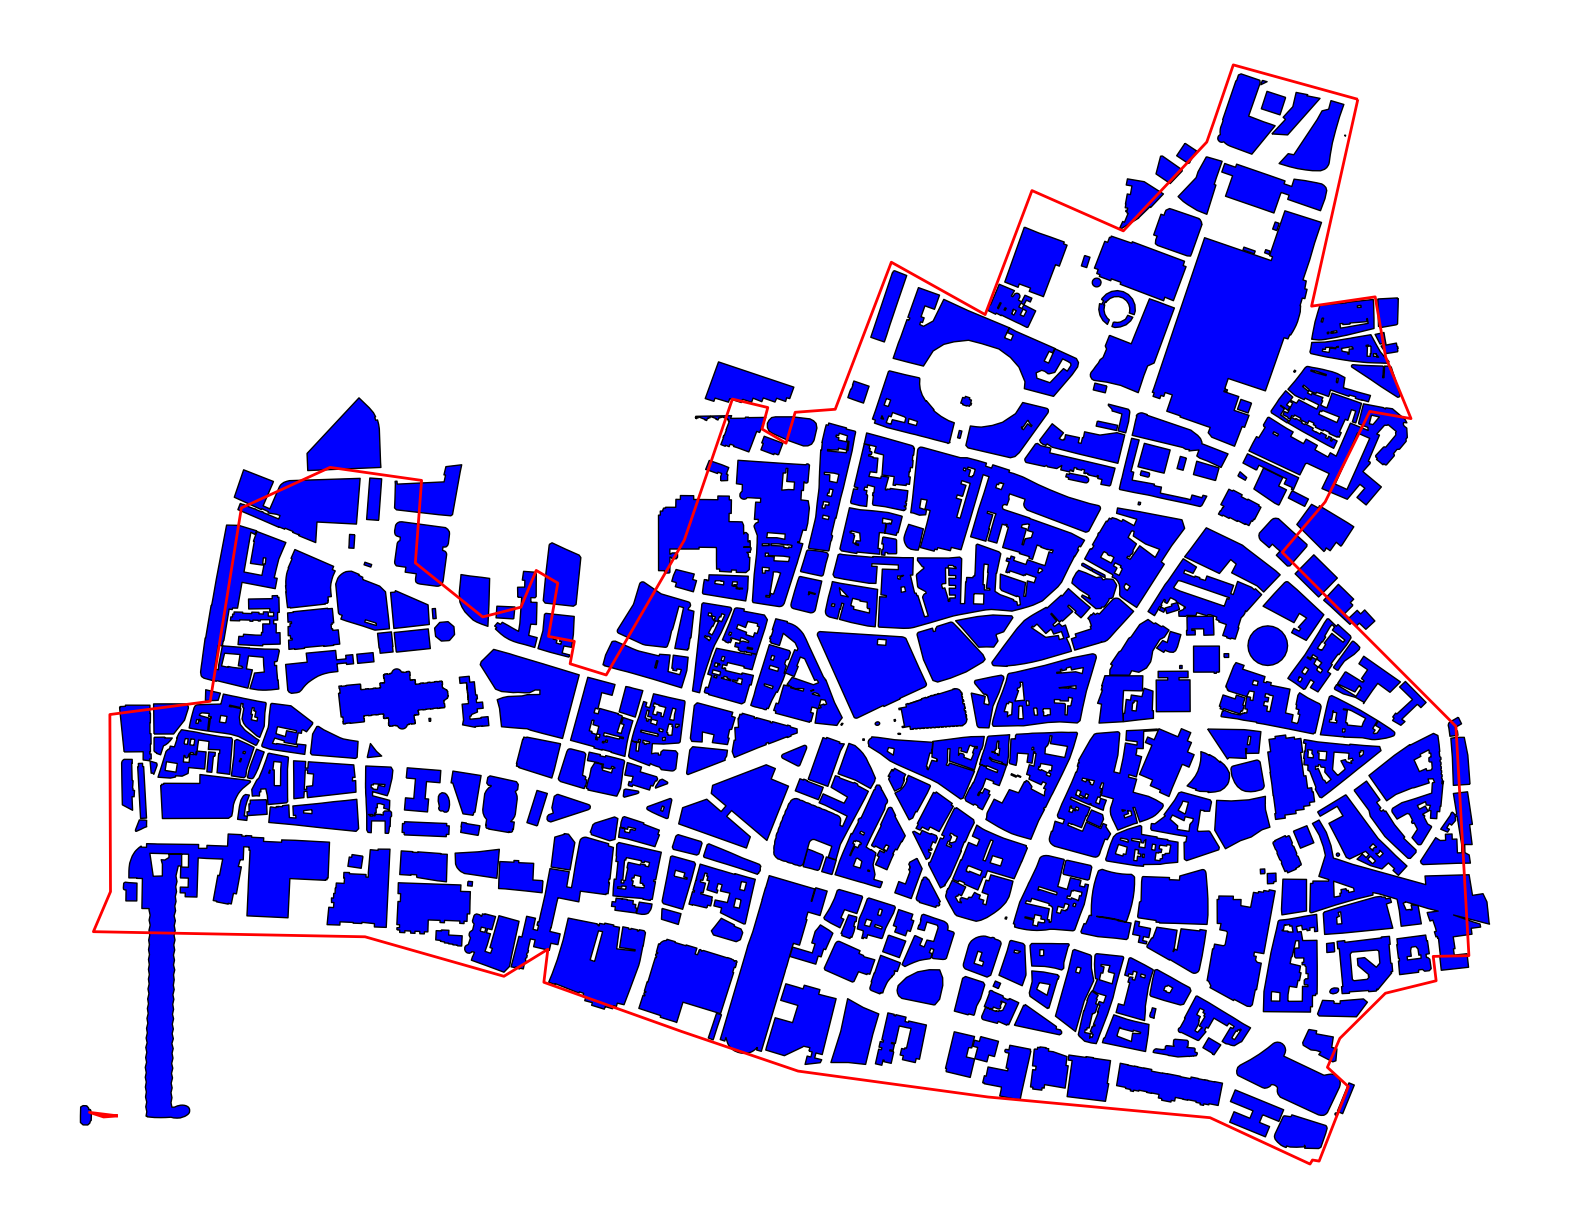

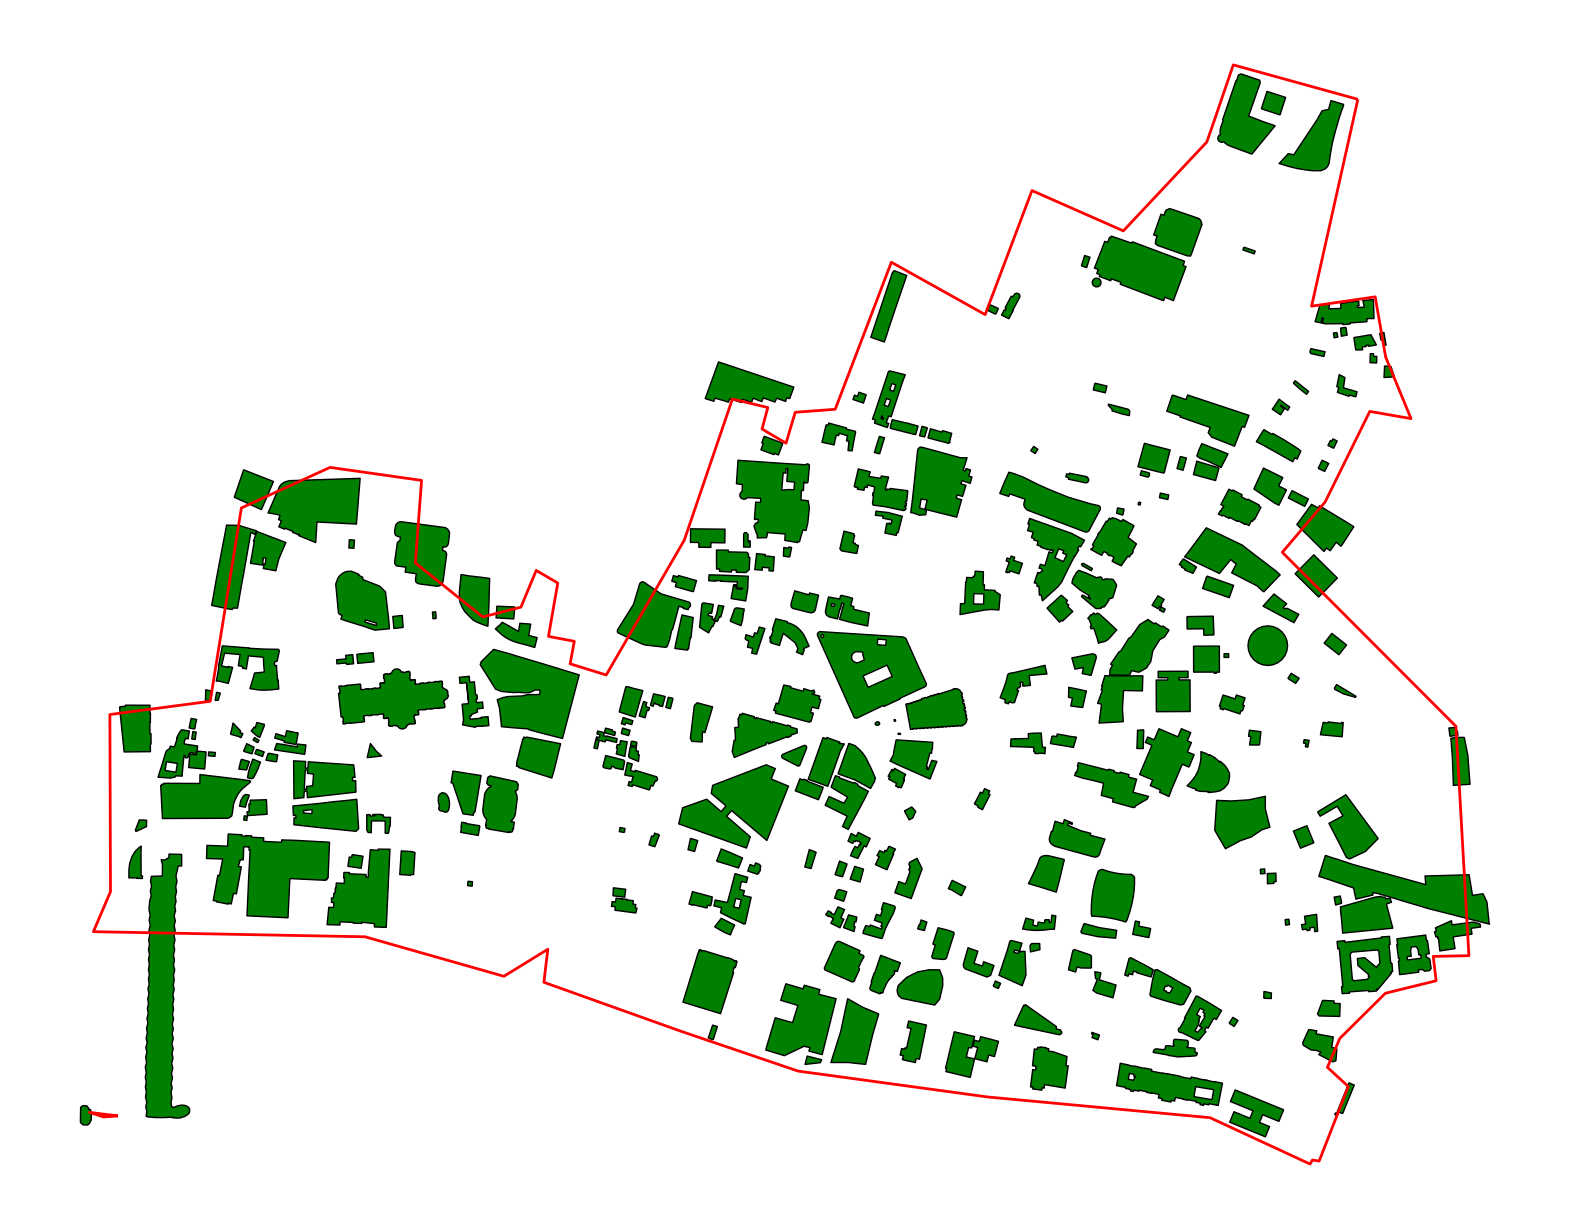

In [140]:
#Get building subset - City of London 001F

#Code from earlier - isolate City of London 001F
lsoa = empl_geog[empl_geog['LSOA11NM_x'] == 'City of London 001F']
geom = lsoa['geometry'].iloc[0]
filter_geom = gpd.GeoSeries([geom], crs=lsoa_geo.crs)

#Get buildings for both
lsoa_osm_buildings = gpd.GeoDataFrame(lsoa, geometry='osm_building_poly')
lsoa_overture_buildings = gpd.GeoDataFrame(lsoa, geometry='overture_building_poly')

# Plot OSM buildings
fig, ax = plt.subplots(figsize=(20, 20))
lsoa_osm_buildings.plot(ax=ax, legend=True, color='blue', edgecolor='black')
filter_geom.boundary.plot(ax=ax, color='red', linewidth=2)
ax.set_axis_off()
plt.show()

# Plot Overture buildings
fig, ay = plt.subplots(figsize=(20, 20))
lsoa_overture_buildings.plot(ax=ay, legend=True, color='green', edgecolor='black')
filter_geom.boundary.plot(ax=ay, color='red', linewidth=2)
ay.set_axis_off()
plt.show()

## Basic Models